In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
SPX_Prices = yf.download('SPY', start='2002-01-01', end='2024-01-01', interval = "1d")
SPX_Prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,115.110001,115.750000,113.809998,115.529999,76.324295,18651900
2002-01-03,115.650002,116.949997,115.540001,116.839996,77.189728,15743000
2002-01-04,117.169998,117.980003,116.550003,117.620003,77.705032,20140700
2002-01-07,117.699997,117.989998,116.559998,116.790001,77.156715,13106500
2002-01-08,116.790001,117.059998,115.970001,116.519997,76.978325,12683700
...,...,...,...,...,...,...
2023-12-22,473.859985,475.380005,471.700012,473.649994,473.649994,67126600
2023-12-26,474.070007,476.579987,473.989990,475.649994,475.649994,55387000
2023-12-27,475.440002,476.660004,474.890015,476.510010,476.510010,68000300


In [107]:
VIX = yf.download('^VIX', start='2002-01-01', end='2024-01-01', interval = "1d")
VIX

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,23.780001,24.200001,22.709999,22.709999,22.709999,0
2002-01-03,22.219999,22.430000,21.330000,21.340000,21.340000,0
2002-01-04,20.969999,21.530001,20.400000,20.450001,20.450001,0
2002-01-07,21.410000,22.150000,21.350000,21.940001,21.940001,0
2002-01-08,21.629999,22.290001,21.280001,21.830000,21.830000,0
...,...,...,...,...,...,...
2023-12-22,13.720000,13.960000,13.000000,13.030000,13.030000,0
2023-12-26,13.770000,13.800000,12.960000,12.990000,12.990000,0
2023-12-27,13.020000,13.040000,12.370000,12.430000,12.430000,0


In [4]:
def garman_klass_daily_variance(data):
    """
    Calculate daily Garman-Klass variance for given price data.
    """
    log_hl = np.log(data['High'] / data['Low'])
    log_co = np.log(data['Close'] / data['Open'])
    daily_variance = 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2
    return daily_variance

In [220]:
def rolling_volatility(data, rolling_window):
    """
    Calculate annualized Garman-Klass volatility over a given period
    """
    Daily_Volatility = garman_klass_daily_variance(data)
    Rolling_Vol = np.sqrt((Daily_Volatility.rolling(rolling_window).mean())*252)
    return Rolling_Vol


In [32]:
daily_vol = rolling_volatility(SPX_Prices, 1)
weekly_vol = rolling_volatility(SPX_Prices, 5)
monthly_vol = rolling_volatility(SPX_Prices, 21)
quartely_vol = rolling_volatility(SPX_Prices, 63)

In [33]:
# Here we remove the NaN values from the volatility metrics
weekly_vol_nan = (weekly_vol[~np.isnan(weekly_vol)])
monthly_vol_nan = (monthly_vol[~np.isnan(monthly_vol)])
quartely_vol_nan = (quartely_vol[~np.isnan(quartely_vol)])
# We go as far back as the minimum of the amount of valid data points
far_back = min(len(weekly_vol_nan) , len(monthly_vol_nan) , len(quartely_vol_nan))
# Adjust the data to be the same size
weekly_vol_nan = weekly_vol_nan[-far_back:]
monthly_vol_nan = monthly_vol_nan[-far_back:]
quartely_vol_nan = quartely_vol_nan[-far_back:]
daily_vol_nan = daily_vol[-far_back:]

In [222]:
volatilities = pd.DataFrame(
    data = {"daily_vol" : daily_vol_nan,
            "weekly_vol" : weekly_vol_nan,
            "monthly_vol" : monthly_vol_nan,
            "quartely_vol" : quartely_vol_nan
           },
    index = (SPX_Prices.index))

volatilities = volatilities.dropna()
volatilities

,daily_vol,weekly_vol,monthly_vol,quartely_vol
Date,,,,
2002-04-03,0.188741,0.141114,0.129831,0.156948
2002-04-04,0.116253,0.141567,0.128777,0.155872
2002-04-05,0.137383,0.145083,0.128437,0.156408
2002-04-08,0.111350,0.136978,0.125265,0.156159
2002-04-09,0.085117,0.132406,0.123316,0.155873
...,...,...,...,...
2023-12-22,0.087123,0.095185,0.080046,0.101953
2023-12-26,0.051613,0.092716,0.080736,0.101349
2023-12-27,0.035382,0.092868,0.080752,0.099901


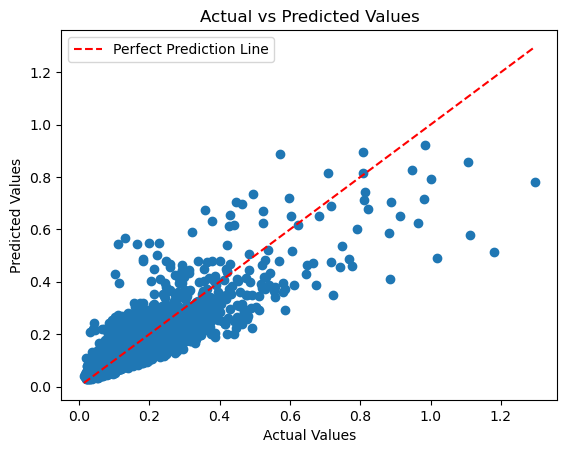

Coefficients (Slope): [ 0.95530808 -0.0420618   0.01360054]
Intercept: 0.003314003394721113


In [210]:
### This is our regression model with only historical volatility as our independent variables ###

# Data with three independent variables (X1, X2, X3) and one dependent variable (Y)
All_Vols = {'X1': weekly_vol_nan,
        'X2': monthly_vol_nan,
        'X3': quartely_vol_nan,
        'Y': daily_vol_nan}

df = pd.DataFrame(All_Vols)

# Separate independent variables (features) and dependent variable
X = df[['X1', 'X2', 'X3']]
y = df['Y']

# Create and fit the multiple regression model
all_preds = LinearRegression()
all_preds.fit(X, y)

# Predictions
y_pred = all_preds.predict(X)

# Plotting the actual vs predicted values
plt.scatter(y, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Print the coefficients (slope) and intercept
print('Coefficients (Slope):', all_preds.coef_)
print('Intercept:', all_preds.intercept_)

In [216]:
# Import the Interest Rates data from FRED
Interest_Rates = pd.read_csv('/Users/anthonyscattini/Documents/UCSB/Junior Year/Winter 2024/Math 104A/Project/FEDFUNDS.csv')
# Make the data frame the same size as the other data
Interest_Rates_df = pd.DataFrame(Interest_Rates[-far_back:])
# make the data frame a series so it can be added to the other data
Interest_Rates_series = pd.Series(intrat['FEDFUNDS'])
# Change the indicies to the same as the other data
Interest_Rates_series.index = df.index

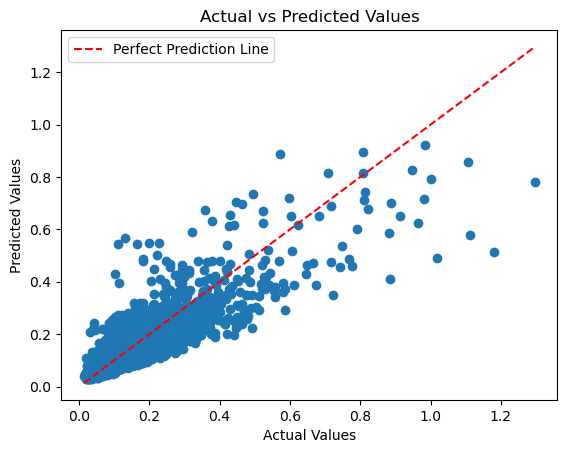

Coefficients (Slope): [ 9.55210295e-01 -4.22250234e-02  1.44969093e-02  1.91081391e-04]
Intercept: 0.002940946820883819


In [219]:
### This is our regression model with historical volatility and Interest Rates as our independent variables ###

# Data with four independent variables (X1, X2, X3, X4) and one dependent variable (Y)
All_Vols = {'X1': weekly_vol_nan,
        'X2': monthly_vol_nan,
        'X3': quartely_vol_nan,
        'X4': Interest_Rates_series,
        'Y': daily_vol_nan}

df = pd.DataFrame(All_Vols)

# Separate independent variables (features) and dependent variable
X = df[['X1', 'X2', 'X3', 'X4']]
y = df['Y']

# Create and fit the multiple regression model
all_preds = LinearRegression()
all_preds.fit(X, y)

# Predictions
y_pred = all_preds.predict(X)

# Plotting the actual vs predicted values
plt.scatter(y, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Print the coefficients (slope) and intercept
print('Coefficients (Slope):', all_preds.coef_)
print('Intercept:', all_preds.intercept_)